# Regression analysis

This notebook demnstrates the regression analysis on

- credibleSetSize
- MAF
- beta

The analysis is performed using random effect model and fixed effect model.

Since this is a meta analysis betwen the different datasets, we need to be sure that we do not invalidate the independence assumption of the regression model, hence we use the `studyType` as a random effect covariate.


## Data Loading

The goal of this notebook is to check the distribution of study types in the dataset.


In [1]:
from gentropy.common.session import Session
from plotnine import (
    aes,
    after_stat,
    element_blank,
    element_line,
    element_rect,
    element_text,
    facet_grid,
    geom_density,
    geom_histogram,
    ggplot,
    labs,
    scale_x_continuous,
    theme,
)
from pyspark.sql import functions as f

from manuscript_methods.datasets import LeadVariantEffect


Loading BokehJS ...

In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead-maf-vep"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/30 11:45:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
session.spark


In [4]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)
dataset = dataset_maf.df.select(
    "rescaledStatistics.estimatedBeta",
    "studyStatistics.studyType",
    f.col("majorLdPopulationMaf").getField("value").alias("MAF"),
    "locusStatistics.locusSize",
)


## Plot the distributions of all variables across study types


In [5]:
data = dataset.toPandas()
data


,estimatedBeta,studyType,MAF,locusSize
0,8.114996,gwas,0.000456,1
1,-1.309428,eqtl,0.230956,4
2,0.446965,sqtl,0.243415,29
3,-0.651588,tuqtl,0.203497,2
4,-0.472081,eqtl,0.425893,5
...,...,...,...,...
2833753,-0.785515,eqtl,0.288496,2
2833754,-0.116795,gwas,0.084892,11
2833755,1.444743,eqtl,0.015777,7
2833756,0.823227,tuqtl,0.326421,12


In [ ]:
REM = 10

plot = (
    ggplot(data, aes(x="MAF", y=after_stat("density")))
    + geom_histogram(bins=10, fill="blue", color="black", alpha=0.7)
    + facet_grid(cols="studyType")
    + theme(
        figure_size=(10, 4.5),  # ~85mm wide
        axis_title=element_text(size=REM * 1, family="sans-serif"),
        axis_text=element_text(size=REM * 0.8, family="sans-serif"),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_ticks=element_line(color="black"),
        axis_line=element_line(color="black"),
        panel_background=element_rect(fill="white"),
        panel_border=element_rect(color="black", fill=None),
        panel_grid=element_blank(),
        plot_margin=0.1,
    )
    + labs(x="Major LD Population MAF", y="Density")
    + geom_density()
    + scale_x_continuous(
        limits=(0, 0.5),
        breaks=[0, 0.5],
        labels=["0", "0.5"],
    )
)
plot


/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 2744 rows containing non-finite values.
/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 2744 rows containing non-finite values.


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 2811 rows containing non-finite values.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_density : Removed 2811 rows containing non-finite values.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 14 rows containing missing values.


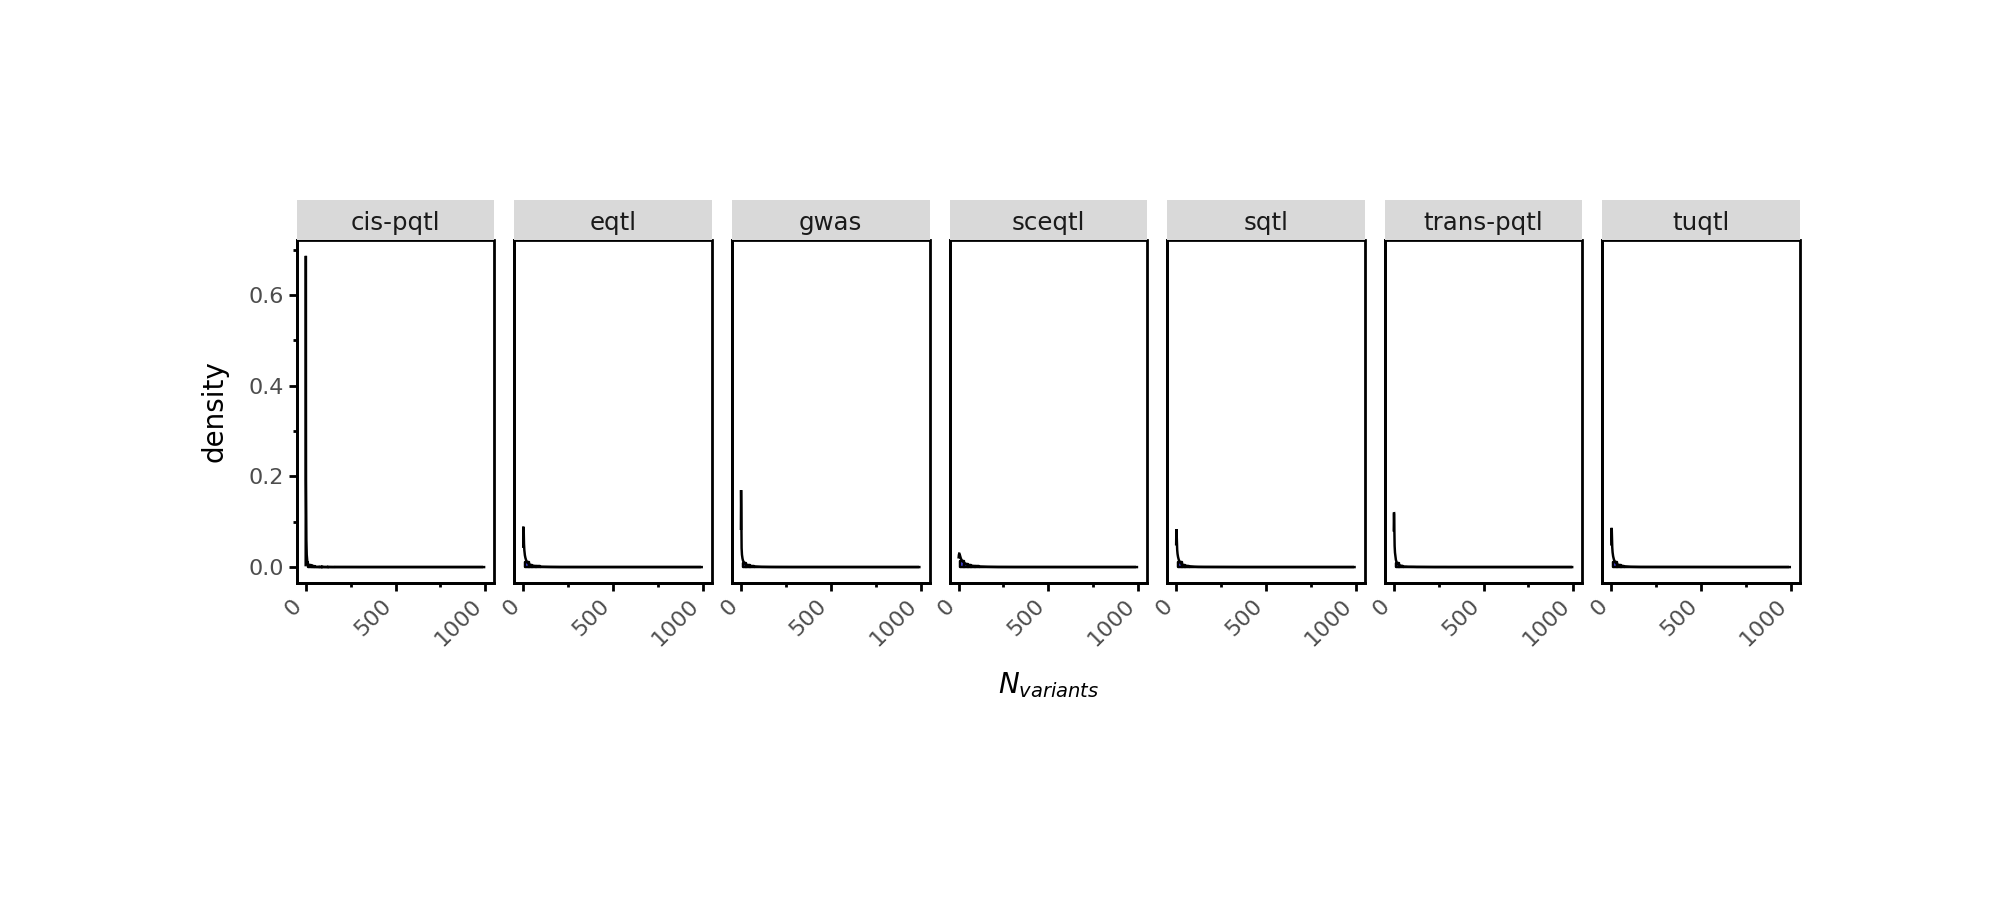

In [7]:
plot = (
    ggplot(data, aes(x="locusSize", y=after_stat("density")))
    + geom_histogram(bins=50, fill="blue", color="black", alpha=0.7)
    + facet_grid(cols="studyType")
    + theme(
        figure_size=(10, 4.5),  # ~85mm wide
        axis_title=element_text(size=REM * 1, family="sans-serif"),
        axis_text=element_text(size=REM * 0.8, family="sans-serif"),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_ticks=element_line(color="black"),
        axis_line=element_line(color="black"),
        panel_background=element_rect(fill="white"),
        panel_border=element_rect(color="black", fill=None),
        panel_grid=element_blank(),
        plot_margin=0.1,
    )
    + labs(x=r"$N_{variants}$", y="density")
    + geom_density()
    + scale_x_continuous(
        limits=(0, 1000),
        breaks=[0, 500, 1000],
        labels=["0", "500", "1000"],
    )
)
plot


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 113746 rows containing non-finite values.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 14 rows containing missing values.


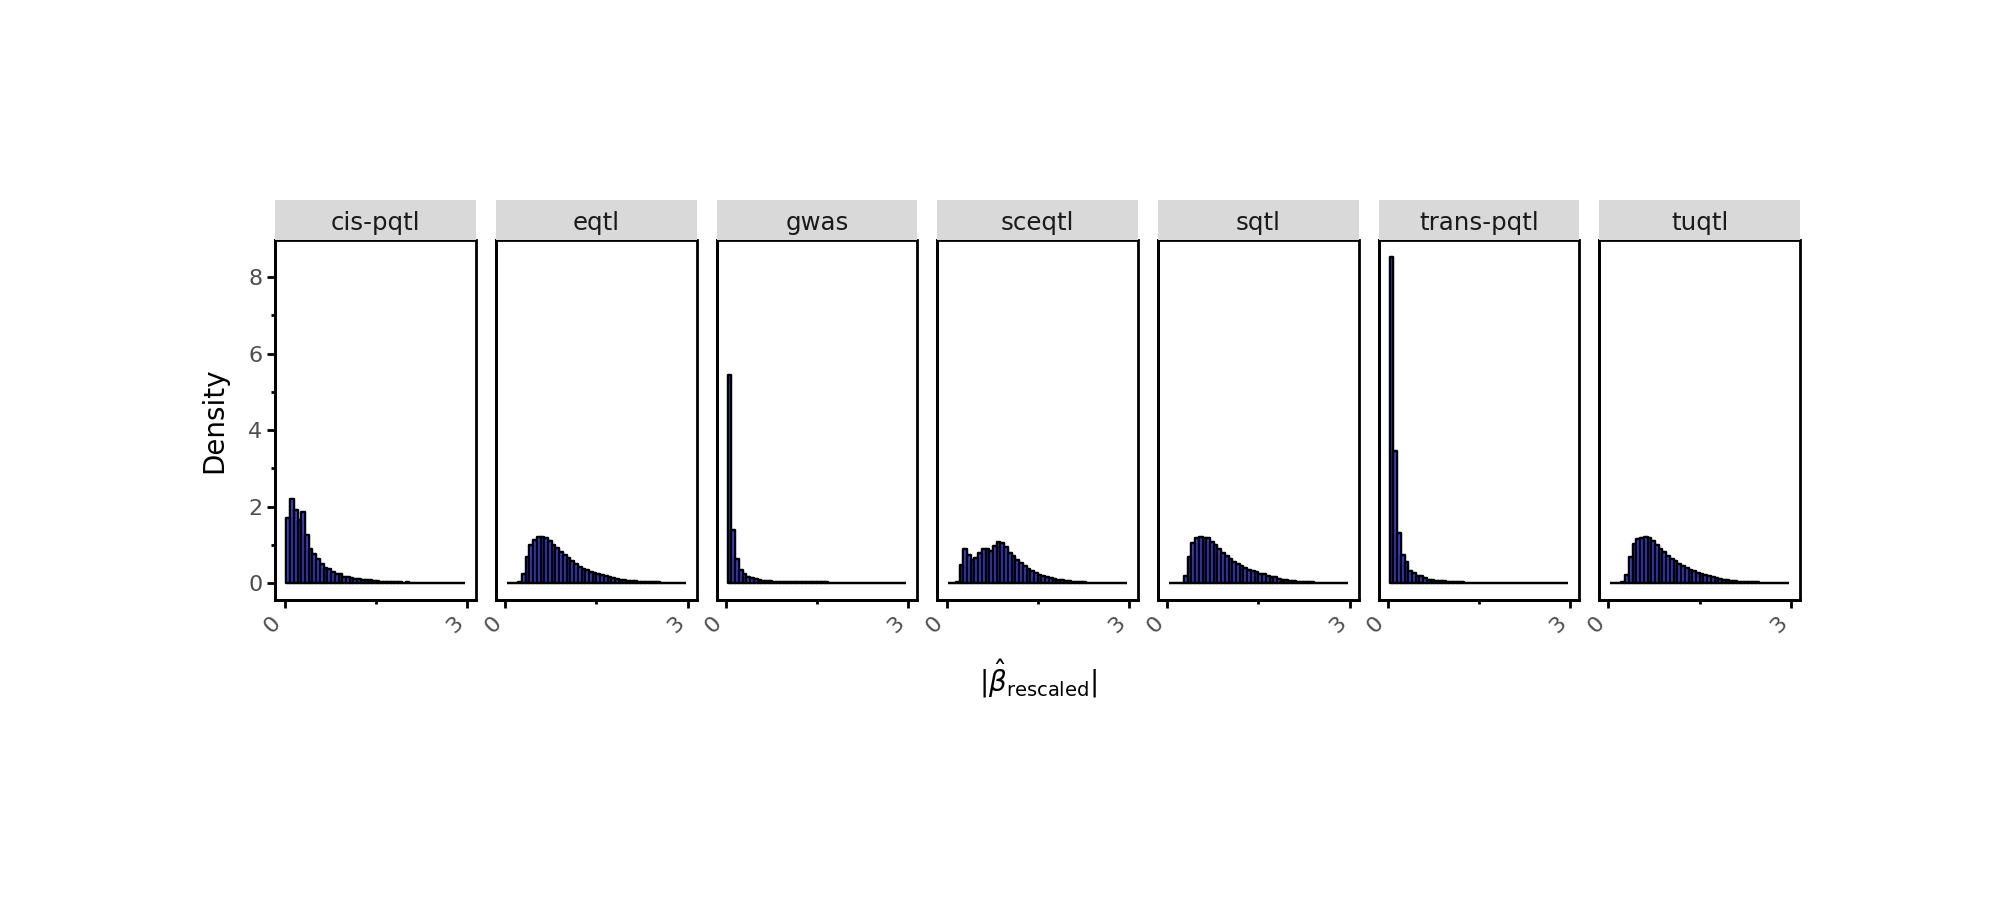

In [8]:
data["absEstimatedBeta"] = data["estimatedBeta"].abs()
plot = (
    ggplot(data, aes(x="absEstimatedBeta", y=after_stat("density")))
    + geom_histogram(bins=50, fill="blue", color="black", alpha=0.7)
    + facet_grid(cols="studyType")
    + theme(
        figure_size=(10, 4.5),  # ~85mm wide
        axis_title=element_text(size=REM * 1, family="sans-serif"),
        axis_text=element_text(size=REM * 0.8, family="sans-serif"),
        axis_text_x=element_text(rotation=45, hjust=1),
        axis_ticks=element_line(color="black"),
        axis_line=element_line(color="black"),
        panel_background=element_rect(fill="white"),
        panel_border=element_rect(color="black", fill=None),
        panel_grid=element_blank(),
        plot_margin=0.1,
    )
    + labs(x=r"$|\hat{\beta}_{\mathrm{rescaled}}|$", y="Density")
    + scale_x_continuous(limits=(0, 3), breaks=[0, 3], labels=["0", "3"])
    # + scale_y_continuous(limits=(0, 1000), breaks=[0, 500, 1000], labels=["0", "500", "1000"])
)
plot


## credible set size vs MAF

Regression according to the model:


In [19]:
data = data.dropna(subset=["MAF", "locusSize", "absEstimatedBeta"]).reset_index(drop=True)


In [ ]:
data


,estimatedBeta,studyType,MAF,locusSize,absEstimatedBeta
0,-0.039763,gwas,0.476350,1,0.039763
1,0.543786,eqtl,0.293208,2,0.543786
2,-0.557317,tuqtl,0.217797,85,0.557317
3,0.094370,gwas,0.022931,20,0.094370
4,0.616734,eqtl,0.338524,8,0.616734
...,...,...,...,...,...
2820463,-0.026049,gwas,0.135948,5,0.026049
2820464,-0.041746,gwas,0.293796,1,0.041746
2820465,-0.917600,eqtl,0.478708,57,0.917600
2820466,-0.722102,eqtl,0.258842,2,0.722102


In [16]:
from statsmodels.formula.api import mixedlm

model = mixedlm("locusSize ~ MAF", data, groups=data["studyType"])
result = model.fit()
print(result.summary())


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


            Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: locusSize     
No. Observations: 2831014  Method:             REML          
No. Groups:       7        Scale:              7518.7107     
Min. group size:  16050    Log-Likelihood:     -16650683.4355
Max. group size:  1349161  Converged:          Yes           
Mean group size:  404430.6                                   
--------------------------------------------------------------
             Coef.    Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------
Intercept     21.391    32.774   0.653  0.514  -42.844  85.627
MAF           18.420     0.339  54.359  0.000   17.756  19.084
Group Var   7518.711                                          



In [21]:
model = mixedlm("absEstimatedBeta ~ MAF", data, groups=data["studyType"])
result = model.fit()
print(result.summary())


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


             Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: absEstimatedBeta
No. Observations: 2820468  Method:             REML            
No. Groups:       7        Scale:              10.0393         
Min. group size:  15933    Log-Likelihood:     -7254829.1057   
Max. group size:  1348868  Converged:          Yes             
Mean group size:  402924.0                                     
----------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept       2.113     1.198     1.765  0.078  -0.234   4.460
MAF            -5.332     0.012  -429.025  0.000  -5.356  -5.307
Group Var      10.039                                           



In [22]:
model = mixedlm("locusSize ~ absEstimatedBeta", data, groups=data["studyType"])
result = model.fit()
print(result.summary())


/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.


             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable: locusSize     
No. Observations:   2820468  Method:             REML          
No. Groups:         7        Scale:              7537.2143     
Min. group size:    15933    Log-Likelihood:     -16592126.3897
Max. group size:    1348868  Converged:          Yes           
Mean group size:    402924.0                                   
---------------------------------------------------------------
                  Coef.   Std.Err.    z    P>|z|  [0.025 0.975]
---------------------------------------------------------------
Intercept          26.238   32.814   0.800 0.424 -38.077 90.552
absEstimatedBeta   -0.704    0.016 -44.541 0.000  -0.735 -0.673
Group Var        7537.214                                      

